# Kernel Mixture Network in PyTorch
This is a quick implementation of a Kernel Mixture Network [The Kernel Mixture Network: A Nonparametric Method for Conditional Density Estimation of Continuous Random Variables](https://arxiv.org/abs/1705.07111) of Ambrogioni et al. (2017). This is a very interesting approach to infer conditional probabilities in an unsupervised manner, specially relevant when the conditional probability can be multimodal. I've looked at this for several reasons:

1. I wanted to learn how to code using PyTorch for different kinds of optimization. I've been using Keras and Tensorflow for neural networks, but I also want to solve complex optimization problems in the future that can be easily solved with PyTorch. I like that the code for any optimization problem is very clean and very similar to how one would code it in `numpy`.
2. I have been trying to solve an inverse problem in solar and stellar spectropolarimetry during some years now. Even though I have a workign inversion code that works nicely, the problem is heavily multimodal and all modes are of interest. Additionally, the forward problem is very computationally heavy, so that an approach that captures the multimodality based on neural networks looks like a fantastic solution.

I refer the reader to the fantastic blog post of [Jan van der Vegt](https://janvdvegt.github.io/2017/06/07/Kernel-Mixture-Networks.html) where he explains in detail different ways of unconditional and conditional density estimation, and the application of Kernel Mixture Networks for this purpose. This notebook is just an implementation of the same technique in PyTorch. My interest here is to understand all the details and also to learn PyTorch. I will scale this to my problem in the near future.

The idea can be easily understood in the Bayesian framework. Assume that we have a certain 1D quantity $y_i$ that is conditioned on a set of observed variables $\mathbf{x}_i$. We observe many such cases and our aim is to propose a certain parametric probabilistic model (depending on the parameters $\mathbf{m}$) for our observed data and compute the posterior distribution over the model parameters. If flat priors are assumed for all model parameters, the posterior can be written as 

$$
p(\mathbf{m}|\mathbf{x},\mathbf{y}) = p(\mathbf{y}|\mathbf{m},\mathbf{x}) = \prod_{i=1}^N p(y_i|\mathbf{m},\mathbf{x}_i),
$$
where we have made the assumption of statistical independence among all $N$ observations. One can find the maximum a-posteriori (or equivalently in this case, the maximum likelihood) solution, by minimizing the negative log-posterior:
$$
-\log p(\mathbf{m}|\mathbf{x},\mathbf{y}) = -\sum_{i=1}^N \log p(y_i|\mathbf{m},\mathbf{x}_i).
$$

In the case of a Kernel Mixture Density, we propose as a model likelihood the following kernelized mixture:

$$
p(y_i|\mathbf{m},\mathbf{x}_i) = \frac{\sum_{j=1}^N w_j(\mathbf{x}_i) K(y_i,y_j;\sigma)}{\sum_{j=1}^N w_j(\mathbf{x}_i)}
$$

In other words, we put a certain kernel at every single observed point and weight this contribution by a quantity that depends on the value of the parameters $\mathbf{x}_i$. According to Ambrogioni et al. (2017), the problem can be simplified if instead of all observed points, one carries out a clustering of the $y$ variable and use the centers of the clusters. The value of the weight will be obtained using a neural network.

In the following I implement three versions of the Kernel Mixture Density.

## Some initial imports and functions

In [108]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
import shutil
import time

In [2]:
torch.cuda.is_available()

False

We get a simple multimodal problem from `sklearn`. This problem is relatively simple, but cannot be solved with standard neural networks.

Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


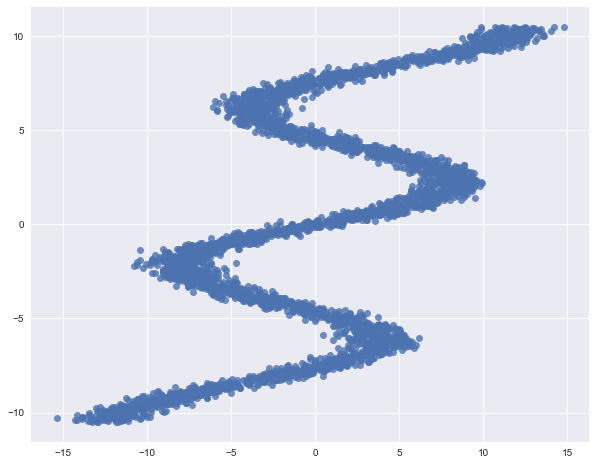

In [3]:
from sklearn.model_selection import train_test_split
def build_toy_dataset(n):
    np.random.seed(41)
    y_data = np.random.uniform(-10.5, 10.5, n)
    r_data = np.random.normal(size=n)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((n, 1))
    return train_test_split(x_data, y_data, random_state=42)

n_observations = 5000  # number of data points
n_features = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(n_observations)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

fig, ax = pl.subplots()
fig.set_size_inches(10, 8)
sns.regplot(X_train, y_train, fit_reg=False)
pl.show()

This function is directly taken from Jan van der Vegt's blog, so I thank him for that. It's used for obtaining the clustering for reducing the complexity of the problem using K-Means.

In [4]:
def sample_center_points(y, method='all', k=100, keep_edges=False):
    """
    function to define kernel centers with various downsampling alternatives
    """

    # make sure y is 1D
    y = y.ravel()

    # keep all points as kernel centers
    if method is 'all':
        return y

    # retain outer points to ensure expressiveness at the target borders
    if keep_edges:
        y = np.sort(y)
        centers = np.array([y[0], y[-1]])
        y = y[1:-1]
        # adjust k such that the final output has size k
        k -= 2
    else:
        centers = np.empty(0)

    if method is 'random':
        cluster_centers = np.random.choice(y, k, replace=False)

    # iteratively remove part of pairs that are closest together until everything is at least 'd' apart
    elif method is 'distance':
        raise NotImplementedError

    # use 1-D k-means clustering
    elif method is 'k_means':
        model = KMeans(n_clusters=k, n_jobs=-2)
        model.fit(y.reshape(-1, 1))
        cluster_centers = model.cluster_centers_

    # use agglomerative clustering
    elif method is 'agglomerative':
        model = AgglomerativeClustering(n_clusters=k, linkage='complete')
        model.fit(y.reshape(-1, 1))
        labels = pd.Series(model.labels_, name='label')
        y_s = pd.Series(y, name='y')
        df = pd.concat([y_s, labels], axis=1)
        cluster_centers = df.groupby('label')['y'].mean().values

    else:
        raise ValueError("unknown method '{}'".format(method))

    return np.append(centers, cluster_centers)

In [9]:
def to_scalar(var):
    # returns a python float
    return var.view(-1).data.tolist()[0]


def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

aa = np.random.randn(50, 1)
aa2 = Variable(torch.from_numpy(aa))
a = log_sum_exp(aa2)
print(np.log(np.sum(np.exp(aa))), a)

4.11770762661 Variable containing:
 4.1177
[torch.DoubleTensor of size 1]



## Different kinds of neural networks for inferring the weights
We code three different versions of the Kernel Mixture Network. One in which the width of the kernels are fixed (we only use Gaussian kernels), one in which they will be estimated during the optimization and a third one in which we propose kernels with different widths. I still don't know which version works better if a suitable value of $\sigma$ is used.

### Single width

In [10]:
class estimator_many_sigma(nn.Module):
  def __init__(self, n_centers, n_sigma):
    super(estimator_many_sigma, self).__init__()
    self.n_centers = n_centers
    self.linear_1 = nn.Linear(1,32)
    self.linear_2 = nn.Linear(32,16)
    self.linear_3 = nn.Linear(16,self.n_centers*n_sigma)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
    
  def forward(self, x):
    out = self.linear_1(x)
    out = self.relu(out)
    out = self.linear_2(out)
    out = self.relu(out)
    out = self.linear_3(out)
    out = self.softmax(out)
    return out

In [124]:
class kmn_torch_many_sigma(object):
    def __init__(self, x_train, y_train, center_sampling_method='k_means', n_centers=20, sigmas=None, keep_edges=True, 
                 estimator=None, validation_set=None, batch_size=32):
        self.center_sampling_method = center_sampling_method
        self.n_centers = n_centers
        self.batch_size = batch_size
        if (sigmas is None):
            self.sigmas = Variable(torch.ones(self.n_centers), requires_grad=False)
        else:
            self.n_sigma = len(sigmas)
            sigmas = torch.from_numpy(sigmas.astype('float32'))
            self.sigma = Variable(sigmas.repeat(self.n_centers,1).view(-1), requires_grad=False)
        self.estimator = estimator(self.n_centers, self.n_sigma)
        self.keep_edges = keep_edges
        center_locs = torch.from_numpy(sample_center_points(y_train, method=self.center_sampling_method, 
                                                k=self.n_centers, keep_edges=self.keep_edges).astype('float32'))
        self.center_locs = Variable(center_locs.repeat(self.n_sigma,1).t().contiguous().view(-1), requires_grad=False)
        
        self.n_data, self.n_features = x_train.shape
        
        x = torch.from_numpy(x_train.reshape(self.n_data, self.n_features).astype('float32'))
        y = torch.from_numpy(y_train.reshape(self.n_data, 1).astype('float32'))
        
        self.x = Variable(x)
        self.y = Variable(y, requires_grad=False)
        
        train_data = data.TensorDataset(x, y)
        self.train_loader = data.DataLoader(dataset=train_data, batch_size=3750, num_workers=0)
        
        self.validation_present = False
        if (validation_set != None):
            self.validation_present = True
            x_val = validation_set['x']
            y_val = validation_set['y']
            self.n_data_val, _ = x_val.shape
            x_val = torch.from_numpy(x_val.reshape(self.n_data_val, self.n_features).astype('float32'))
            y_val = torch.from_numpy(y_val.reshape(self.n_data_val, 1).astype('float32'))
            
            self.x_val = Variable(x_val, requires_grad=False)
            self.y_val = Variable(y_val, requires_grad=False)
            
            test_data = data.TensorDataset(x_val, y_val)
            self.validation_loader = data.DataLoader(dataset=test_data, batch_size=self.batch_size)
            
        self.oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
            
    def gaussian_distribution(self, y, mu, sigma):
        result = (y - mu) * torch.reciprocal(sigma)
        result = - 0.5 * (result * result)
        return (torch.exp(result) * torch.reciprocal(sigma)) * self.oneDivSqrtTwoPI
    
    def mdn_loss_function(self, weights, y):
        result = self.gaussian_distribution(y, self.center_locs, self.sigma) * weights
        result = torch.sum(result, dim=1)
        result = - torch.log(result)
        return torch.mean(result)
                       
    def train(self, epoch):
        self.estimator.train()
        end = time.time()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            #print(time.time() - end)
            data, target = Variable(data), Variable(target)
            
            weights = self.estimator(data)
            loss = self.mdn_loss_function(weights, target)
            self.loss.append(loss.data.numpy())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    def train2(self, epoch):
        self.estimator.train()
        
        weights = self.estimator(self.x)
        loss = self.mdn_loss_function(weights, self.y)
        self.loss.append(loss.data.numpy())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
    def test(self):
        if (self.validation_present):
            for batch_idx, (data, target) in enumerate(self.validation_loader):
                data, target = Variable(data, volatile=True), Variable(target)
                self.estimator.eval()
                weights_val = self.estimator(data)
                loss_val = self.mdn_loss_function(weights_val, target)
                self.loss_val.append(loss_val.data.numpy())
                
    def test2(self):
        if (self.validation_present):
            self.estimator.eval()
            weights_val = self.estimator(self.x_val)
            loss_val = self.mdn_loss_function(weights_val, self.y_val)
            self.loss_val.append(loss_val.data.numpy())
        
    def fit(self, learning_rate=0.01, n_epochs=300):
        self.optimizer = torch.optim.Adam(self.estimator.parameters(), lr=learning_rate)
        self.loss = []
        self.loss_val = []
        best_loss = 1e10
        for epoch in range(1, n_epochs + 1):
            self.train(epoch)
            self.test()
            
            is_best = self.loss_val[-1] > best_loss
            best_loss = max(self.loss_val[-1], best_loss)
            save_checkpoint({
                'epoch': epoch + 1,
                #'arch': args.arch,
                'state_dict': self.estimator.state_dict(),
                'best_loss': best_loss,
                'optimizer' : self.optimizer.state_dict(),
            }, is_best)
            
            if (epoch % 10 == 0):
                if (self.validation_present):
                    print('Iter: {0} - loss: {1} - loss_val: {2}'.format(epoch, self.loss[-1], 
                                                                                      self.loss_val[-1]))
                else:
                    print('Iter: {0} - loss: {1}'.format(epoch, loss.data[0]))
            
    def predict_density(self, x_test):
        y = Variable(torch.linspace(-10,10,300), requires_grad=False)
        weights = self.estimator(x_test)
        result = self.gaussian_distribution(torch.unsqueeze(y,1), self.center_locs, self.sigma) * weights
        result = torch.sum(result, dim=1)
        return y.data.numpy(), result
    
    def sample_density(self, x_test):
        weights = self.estimator(x_test).data.numpy()
        locs = self.center_locs.data.numpy()
        sigma = self.sigma.data.numpy()
        n = x_test.size()[0]
        out = np.zeros(n)
        for i in range(n):
            ind = np.random.choice(self.n_centers * self.n_sigma, p=weights[i,:])
            out[i] = np.random.normal(loc=locs[ind], scale=sigma[ind])
        return out
    
    def plot_loss(self):
        f, ax = pl.subplots()
        ax.plot(np.array(self.loss), label='Training set')
        if (self.validation_present):
            ax.plot(np.array(self.loss_val), label='Validation set')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.legend()

In [125]:
sigmas = np.array([0.5]).astype('float32')
out = kmn_torch_many_sigma(X_train, y_train, estimator=estimator_many_sigma, n_centers=50, sigmas=sigmas,
                           validation_set={'x': X_test, 'y': y_test}, batch_size=1000)
out.fit(learning_rate=0.01, n_epochs=100)

Iter: 10 - loss: [ 2.42202997] - loss_val: [ 2.48526478]
Iter: 20 - loss: [ 2.23375273] - loss_val: [ 2.28968334]
Iter: 30 - loss: [ 2.09623981] - loss_val: [ 2.13812947]
Iter: 40 - loss: [ 1.94910192] - loss_val: [ 1.98616099]
Iter: 50 - loss: [ 1.8224107] - loss_val: [ 1.86638713]
Iter: 60 - loss: [ 1.74638081] - loss_val: [ 1.78695309]
Iter: 70 - loss: [ 1.70413017] - loss_val: [ 1.74063516]
Iter: 80 - loss: [ 1.67904341] - loss_val: [ 1.72464037]
Iter: 90 - loss: [ 1.66529191] - loss_val: [ 1.70604444]
Iter: 100 - loss: [ 1.65835416] - loss_val: [ 1.7091614]


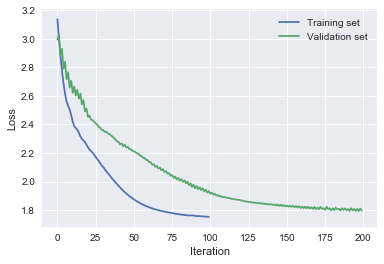

In [86]:
out.plot_loss()

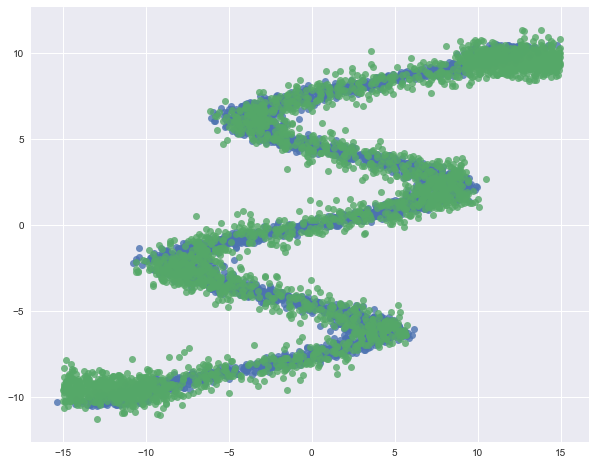

In [58]:
x_test = np.random.rand(3000,1) * 30.0 - 15.0
x_test = Variable(torch.from_numpy(x_test.astype('float32')), requires_grad=False)
res = out.sample_density(x_test)

fig, ax = pl.subplots()
fig.set_size_inches(10, 8)
sns.regplot(X_train, y_train, fit_reg=False)
sns.regplot(x_test.data.numpy().flatten(), res, fit_reg=False)

### Several widths

In [231]:
sigmas = np.array([0.5,1.0,1.5]).astype('float32')
out = kmn_torch_many_sigma(X_train, y_train, estimator=estimator_many_sigma, n_centers=50, sigmas=sigmas,
                           validation_set={'x': X_test, 'y': y_test})
out.fit(learning_rate=0.01, n_iterations=300)

Iter: 0 - loss: 3.0653364658355713 - loss_val: 3.065084457397461
Iter: 100 - loss: 1.6940007209777832 - loss_val: 1.7203209400177002
Iter: 200 - loss: 1.6618090867996216 - loss_val: 1.6915433406829834


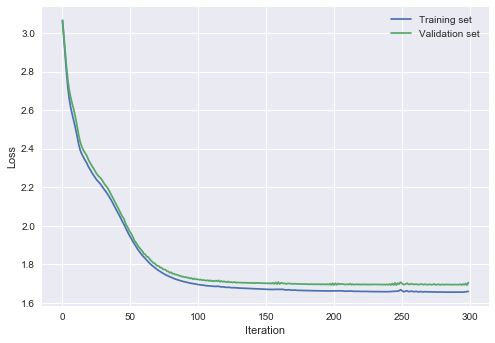

In [232]:
out.plot_loss()

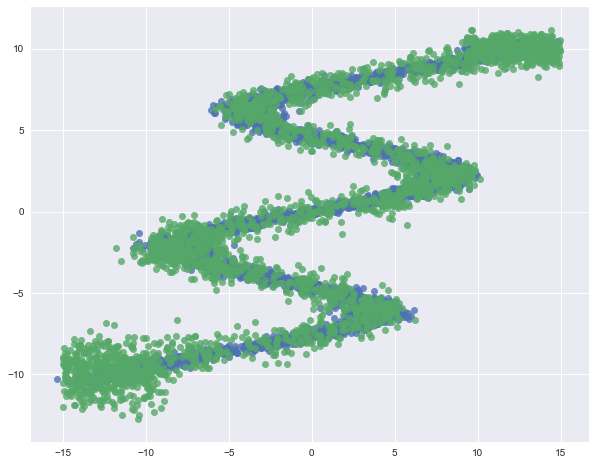

In [233]:
x_test = np.random.rand(3000,1) * 30.0 - 15.0
x_test = Variable(torch.from_numpy(x_test.astype('float32')), requires_grad=False)
res = out.sample_density(x_test)

fig, ax = pl.subplots()
fig.set_size_inches(10, 8)
sns.regplot(X_train, y_train, fit_reg=False)
sns.regplot(x_test.data.numpy().flatten(), res, fit_reg=False)

### Infer width

In [234]:
class estimator_infer_sigma(nn.Module):
  def __init__(self, n_centers):
    super(estimator_infer_sigma, self).__init__()
    self.n_centers = n_centers
    self.linear_1 = nn.Linear(1,32)
    self.linear_2 = nn.Linear(32,16)
    self.linear_3 = nn.Linear(16,self.n_centers)
    self.linear_4 = nn.Linear(16,1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
    self.softplus = nn.Softplus()
    
  def forward(self, x):
    out = self.linear_1(x)
    out = self.relu(out)
    out = self.linear_2(out)
    out = self.relu(out)
    out1 = self.linear_3(out)
    out1 = self.softmax(out1)
    out2 = self.linear_4(out)
    out2 = self.softplus(out2)
    return torch.cat([out1, out2], dim=1)

In [235]:
class kmn_torch_infer_sigma(object):
    def __init__(self, x_train, y_train, center_sampling_method='k_means', n_centers=20, keep_edges=True, 
                 estimator=None, validation_set=None):
        self.center_sampling_method = center_sampling_method
        self.n_centers = n_centers
        self.estimator = estimator(self.n_centers)
        self.keep_edges = keep_edges
        self.sigma = Variable(0.5*torch.ones(self.n_centers), requires_grad=False)
        self.center_locs = Variable(torch.from_numpy(sample_center_points(y_train, method=self.center_sampling_method, 
                                                k=self.n_centers, keep_edges=self.keep_edges).astype('float32')), requires_grad=False)
        
        self.n_data, self.n_features = x_train.shape
        
        self.x = Variable(torch.from_numpy(x_train.reshape(self.n_data, self.n_features).astype('float32')))
        self.y = Variable(torch.from_numpy(y_train.reshape(self.n_data, 1).astype('float32')), requires_grad=False)
        
        self.validation_present = False
        if (validation_set != None):
            self.validation_present = True
            x_val = validation_set['x']
            y_val = validation_set['y']
            self.n_data_val, _ = x_val.shape
            self.x_val = Variable(torch.from_numpy(x_val.reshape(self.n_data_val, self.n_features).astype('float32')), requires_grad=False)
            self.y_val = Variable(torch.from_numpy(y_val.reshape(self.n_data_val, 1).astype('float32')), requires_grad=False)
        
        self.oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
            
    def gaussian_distribution(self, y, mu, sigma):
        result = (y - mu) * torch.reciprocal(sigma)
        result = - 0.5 * (result * result)
        return (torch.exp(result) * torch.reciprocal(sigma)) * self.oneDivSqrtTwoPI
    
    def mdn_loss_function(self, weights, sigma, y):
        result = self.gaussian_distribution(y, self.center_locs, sigma) * weights
        result = torch.sum(result, dim=1)
        result = - torch.log(result)
        return torch.mean(result)
                        
    def fit(self, learning_rate=0.01, n_iterations=300):
        optimizer = torch.optim.Adam(self.estimator.parameters(), lr=learning_rate)
        self.loss = []
        self.loss_val = []
        for i in range(n_iterations):
            out = self.estimator(self.x)
            weights = out[:,0:-1]
            sigma = torch.unsqueeze(out[:,-1], dim=1)
            loss = self.mdn_loss_function(weights, sigma, self.y)
            self.loss.append(loss.data.numpy())
            
            if (self.validation_present):
                out = self.estimator(self.x_val)
                weights_val = out[:,0:-1]
                sigma_val = torch.unsqueeze(out[:,-1], dim=1)
                loss_val = self.mdn_loss_function(weights_val, sigma_val, self.y_val)
                self.loss_val.append(loss_val.data.numpy())
            
            if (i % 100 == 0):
                if (self.validation_present):
                    print('Iter: {0} - loss: {1} - loss_val: {2} - sigma: {3}'.format(i, loss.data[0], 
                                                                                      loss_val.data[0], out[0,-1].data.numpy()))
                else:
                    print('Iter: {0} - loss: {1}'.format(i, loss.data[0]))
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    def predict_density(self, x_test):
        y = Variable(torch.linspace(-10,10,300), requires_grad=False)
        out = self.estimator(x_test)
        weights = out[:,0:-1]
        sigma = torch.unsqueeze(out[:,-1], dim=1)
        result = self.gaussian_distribution(torch.unsqueeze(y,1), self.center_locs, sigma) * weights
        result = torch.sum(result, dim=1)
        return y.data.numpy(), result
    
    def sample_density(self, x_test):
        out = self.estimator(x_test)
        weights = (out[:,0:-1]).data.numpy()
        sigma = (torch.unsqueeze(out[:,-1], dim=1)).data.numpy()
        locs = self.center_locs.data.numpy()
        n = x_test.size()[0]
        out = np.zeros(n)
        for i in range(n):
            ind = np.random.choice(self.n_centers, p=weights[i,:])
            out[i] = np.random.normal(loc=locs[ind], scale=sigma[ind])
        return out
    
    def plot_loss(self):
        f, ax = pl.subplots()
        ax.plot(np.array(self.loss), label='Training set')
        if (self.validation_present):
            ax.plot(np.array(self.loss_val), label='Validation set')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.legend()

In [236]:
out = kmn_torch_infer_sigma(X_train, y_train, estimator=estimator_infer_sigma, n_centers=50, validation_set={'x': X_test, 'y': y_test})
out.fit(learning_rate=0.01)

Iter: 0 - loss: 3.1545560359954834 - loss_val: 3.151036262512207 - sigma: [ 0.71832621]
Iter: 100 - loss: 1.4133799076080322 - loss_val: 1.460314393043518 - sigma: [ 0.16363166]
Iter: 200 - loss: 1.3708522319793701 - loss_val: 1.4355939626693726 - sigma: [ 0.17335534]


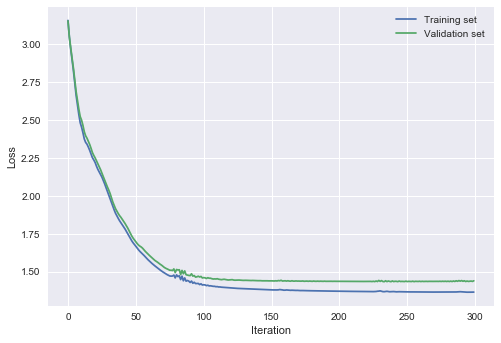

In [237]:
out.plot_loss()

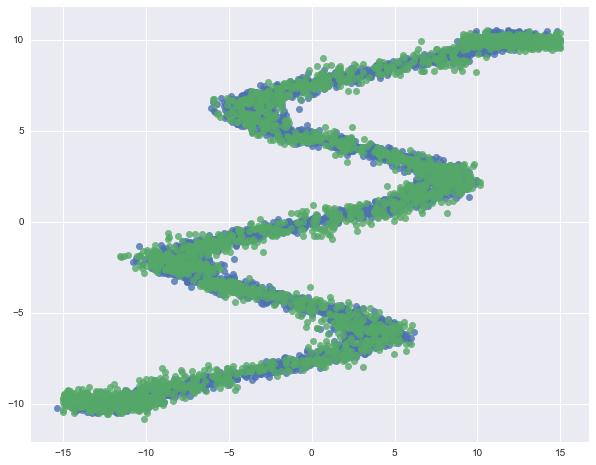

In [238]:
x_test = np.random.rand(3000,1) * 30.0 - 15.0
x_test = Variable(torch.from_numpy(x_test.astype('float32')), requires_grad=False)
res = out.sample_density(x_test)

fig, ax = pl.subplots()
fig.set_size_inches(10, 8)
sns.regplot(X_train, y_train, fit_reg=False)
sns.regplot(x_test.data.numpy().flatten(), res, fit_reg=False)

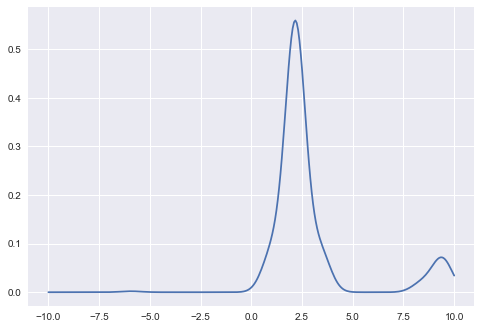

In [196]:
x_test = Variable(7*torch.ones((1,1)), requires_grad=False)
y, prob = out.predict_density(x_test)
pl.plot(y, prob.data.numpy())